Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [2]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/maxudong1993/deep-image-prior.git
# !mv deep-image-prior/* ./
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/xudong/deep-image-prior
!pwd

/content/gdrive/MyDrive/xudong/deep-image-prior
/content/gdrive/MyDrive/xudong/deep-image-prior


# Import libs

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import inspect

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *
import skimage.restoration as rst
import scipy

#?enable best algorithm for hardware  
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
# dtype = torch.cuda.DoubleTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [ ]:
#Test Save the input images as gray image
# image_path = '/content/data/data/medical/'
# image1_pil = get_image(fname_us, imsize)[0]
# image2_pil = get_image(fname_mr, imsize)[0]
# print(image1_pil)
# #3 channels of gray images are almost the same, so only keep one channel
# image1_np = pil_to_np(image1_pil)[0][None,:]
# image2_np = pil_to_np(image2_pil)[0][None,:]
# image1 = np_to_pil(image1_np).save(image_path+'grayMed1.jpg')
# image2 = np_to_pil(image2_np).save(image_path+'grayMed2.jpg')
# print(image1_np.shape)

# Deconvolution


# Load images

In [5]:
def load_images():
    global us_single_np, mr_single_np, us_noisy_np, mr_noisy_np
    us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=1)
    print('us_noisy_pil:',us_noisy_pil)
    us_single_np = pil_to_np(us_noisy_pil)
    us_noisy_np = us_single_np


    mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=1)
    mr_single_np = pil_to_np(mr_noisy_pil)
    mr_noisy_np = mr_single_np
    

def copy_source():
    global us_noisy_np, mr_noisy_np
    us_noisy_np = np.broadcast_to(us_single_np,[channels,us_single_np.shape[1],us_single_np.shape[2]])
    print('us_noisy_np.shape:',us_noisy_np.shape)
    mr_noisy_np = np.broadcast_to(mr_single_np,[channels,mr_single_np.shape[1],mr_single_np.shape[2]])
    print('mr_noisy_np.shape:',mr_noisy_np.shape)
  


# **Compute sensor gain**

In [19]:
# As we don't have ground truth
#compute sensor gain
def compute_sg(mbSize):
    global us_single_sg_np, mr_single_sg_np, us_sg_np, mr_sg_np
    if RGB == True:
        us_sg_r, mr_sg_r = sensor_gain(us_noisy_np[0],mr_noisy_np[0],mbSize)
        us_sg_g, mr_sg_g = sensor_gain(us_noisy_np[1],mr_noisy_np[1],mbSize)
        us_sg_b, mr_sg_b = sensor_gain(us_noisy_np[2],mr_noisy_np[2],mbSize)
        us_sg_np = np.array([us_sg_r, us_sg_g, us_sg_b])
        mr_sg_np = np.array([mr_sg_r, mr_sg_g, mr_sg_b])
    else:
        us_sg, mr_sg = sensor_gain(us_noisy_np[0],mr_noisy_np[0],mbSize=1)
        us_single_sg_np = us_sg[None,:] #numpy is [1,*,*] rather than [*,*]
        mr_single_sg_np = mr_sg[None,:]
        us_sg_np = us_single_sg_np
        mr_sg_np = mr_single_sg_np
    plot_image_grid([us_noisy_np,mr_noisy_np], 4, 5)
    plot_image_grid([us_sg_np,mr_sg_np], 4, 5)

def copy_sg():
    global us_sg_torch, mr_sg_torch
    if RGB == False:
        us_sg_np = np.broadcast_to(us_single_sg_np,[channels,us_single_sg_np.shape[1],us_single_sg_np.shape[2]])
        mr_sg_np = np.broadcast_to(mr_single_sg_np,[channels,mr_single_sg_np.shape[1],mr_single_sg_np.shape[2]])
    print('us_sg_np shape:',us_sg_np.shape)
    us_sg_torch = np_to_torch(us_sg_np).type(dtype).to(device = 'cuda')
    mr_sg_torch = np_to_torch(mr_sg_np).type(dtype).to(device = 'cuda')
    print('us_sg_torch shape:',us_sg_torch.shape)
    print('******************************sensor gain computation finish****************************')

## Set network

In [7]:
def setup_network():
    global net, net_input, s, mse, us_noisy_torch, mr_noisy_torch, exp_weight, LR, OPTIMIZER, figsize
    global OPT_OVER, net, OPTIMIZE
    INPUT = 'noise' # 'meshgrid'
    pad = 'reflection'
    OPT_OVER = 'net' # 'net,input'
    KERNEL_TYPE='lanczos2'
    reg_noise_std = 1./30. # set to 1./20. for sigma=50
    LR = 0.01
    OPTIMIZER='adam' # 'LBFGS'
    exp_weight=0.99

    input_depth = input_size
    figsize = 5 

    NET_TYPE = 'skip' # UNet, ResNet

    if RGB == True:
        net = get_net(input_depth, 'skip', pad,
                      n_channels=3,
                      skip_n33d=128, 
                      skip_n33u=128, 
                      skip_n11=4, 
                      num_scales=5,
                      upsample_mode='bilinear').type(dtype)
    else:
        net = get_net(input_depth, 'skip', pad,
                          n_channels=channels,
                          skip_n33d=128, 
                          skip_n33u=128, 
                          skip_n11=4, 
                          num_scales=5,
                          upsample_mode='bilinear').type(dtype)

    #net input is white noise
    net_input = get_noise(input_depth, INPUT, (us_noisy_np.shape[2], us_noisy_np.shape[1])).type(dtype).detach()
    print('net_input:',net_input.shape)

    # Compute number of parameters
    s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
    print ('Number of params: %d' % s)

    # Loss
    mse = torch.nn.MSELoss().type(dtype)

    #prepare source
    us_noisy_torch = np_to_torch(us_noisy_np).type(dtype)
    mr_noisy_torch = np_to_torch(mr_noisy_np).type(dtype)
    print('******************************Setup Network finish***************************')

## Optimise for MR and US

In [ ]:
#save input only for one channle image
# input_np = torch_to_np(net_input)*10
# input_pil = np_to_pil(input_np)
# print(input_path)
# input_pil.save(input_path)

In [8]:
# net_input_saved = net_input.detach().clone()
# noise = net_input.detach().clone()
def closure():

    global i, out_avg, psrn_noisy_last, last_net, best_loss, best_out, best_avg, best_i, middle_out, middle_out_index
    out = net(net_input)
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    if RGB == True:  #loss computation has problems
        us_r = torch.nn.functional.conv2d(out[0][0].unsqueeze(0).unsqueeze(0),us_psf_torch[0][0].unsqueeze(0).unsqueeze(0),padding = 2)
        us_g = torch.nn.functional.conv2d(out[0][1].unsqueeze(0).unsqueeze(0),us_psf_torch[0][1].unsqueeze(0).unsqueeze(0),padding = 2)
        us_b = torch.nn.functional.conv2d(out[0][2].unsqueeze(0).unsqueeze(0),us_psf_torch[0][1].unsqueeze(0).unsqueeze(0),padding = 2)
        out_us_psf = torch.cat((us_r,us_g,us_b),1)
        # print('out_us_psf.shape:',out_us_psf.shape)
        mr_r = torch.nn.functional.conv2d(out[0][0].unsqueeze(0).unsqueeze(0),mr_psf_torch[0][0].unsqueeze(0).unsqueeze(0),padding = 2)
        mr_g = torch.nn.functional.conv2d(out[0][1].unsqueeze(0).unsqueeze(0),mr_psf_torch[0][1].unsqueeze(0).unsqueeze(0),padding = 2)
        mr_b = torch.nn.functional.conv2d(out[0][2].unsqueeze(0).unsqueeze(0),mr_psf_torch[0][1].unsqueeze(0).unsqueeze(0),padding = 2)
        out_mr_psf = torch.cat((mr_r,mr_g,mr_b),1)
        total_loss = torch.norm((us_sg_torch * out_us_psf - us_noisy_torch),p=2) + torch.norm((mr_sg_torch * out_mr_psf - mr_noisy_torch),p=2) 
    else:
        # print('heerere')
        total_loss = torch.norm((us_sg_torch * out - us_noisy_torch),p=2) + torch.norm((mr_sg_torch * out - mr_noisy_torch),p=2) 
  
    if total_loss < best_loss:
        best_loss = total_loss
        best_out = out
        best_avg = out_avg
        best_i = i
    if i in middle_out_index:
        middle_out[i] = out
    
    total_loss.backward()
        
    
    ####only us image
    psrn_noisy = compare_psnr(us_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(us_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(us_noisy_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    # print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np_avg = torch.mean(out, dim =1).detach().cpu().numpy()
        print("iteration = ",i)
        print(total_loss)
        if channels != 3:
            plot_image_grid([np.clip(us_noisy_np[0][None,:],0,1),np.clip(mr_noisy_np[0][None,:],0,1),np.clip(out_np_avg, 0, 1)], factor=figsize, nrow=4)
        else:
            plot_image_grid([np.clip(us_noisy_np,0,1),np.clip(mr_noisy_np,0,1),np.clip(out_np_avg, 0, 1)], factor=figsize, nrow=4)   
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1
    return total_loss

# Save results

In [9]:
def save_result(): 
    print("Best iteration is: ",best_i)
    print("Best loss is: ",best_loss)
    print("Best result as shown below:")

    #save best result
    if RGB == False:
        print('Not RGB image')
        print('best out torch shape:',best_out.shape)
        best_out_np = torch.mean(best_out, dim =1).detach().cpu().numpy()
        best_avg_np = torch.mean(best_avg, dim =1).detach().cpu().numpy()
        plot_image_grid([best_out_np, best_avg_np], factor=figsize, nrow=4)
        fusion_np = best_out_np
    else:
        fusion_np = torch_to_np(best_out)
    print('fusion np shape:',fusion_np.shape)
    fusion_pil = np_to_pil(fusion_np)
    print(output_path)
    # fusion_pil.save('/content/data/data/medical/grayMed_in1k_out1.png')
    fusion_pil.save(output_path)
    print(fusion_pil)
    print('******************************save result finish****************************')
# matplotlib.image.imsave('/content/data/data/medical/grayClock_myRGB_nopsf_3_graout.png', gray_fusion,cmap ='gray')

# fusion_avg = torch_to_np(best_avg).transpose(1,2,0)
# plt.imsave('/content/data/data/clocks/grayClock_myRGB_nopsf_1channel.png',fusion)
# plt.imsave('/content/data/data/clocks/grayClock_myRGB_nopsf_avg_1channel.png',fusion_avg)

# Set parameters

In [26]:
def set_per_image():
    global fname_us, fname_mr, show_every, RGB, iName
    show_every = 200
    RGB = False #if the image is RGB model   
    # fname_us = './data/data/UNcamp/UNcamp_2N_i_20.bmp'
    # fname_mr = './data/data/UNcamp/UNcamp_2N_v_20.bmp'
    fname_us = './data/data/clocks/gray_clock1.jpg'
    fname_mr = './data/data/clocks/gray_clock2.jpg'
    # fname_us = './data/denoising/VIS1.png'
    # fname_mr = './data/denoising/IR1.png'

    # fname_us = './data/data/phantom/us1_256.png'
    # fname_mr = './data/data/phantom/mr1_256.png'

    # fname_us = './data/denoising/clock1.jpg'
    # fname_mr = './data/denoising/clock2.jpg'
    
    # input_path = ('./data/data/medical/'+iName+'_input.png')
    
    # fname_us, fname_mr = samesize_images(fname_us, fname_mr) #BiCubic magtify
    
    # fname_us = './data/data/medical/grayMed1.jpg'
    # fname_mr = './data/data/medical/grayMed2.jpg'  
    iName = 'clocks'
    print('fname_us path:'+fname_us)
    print('fname_mr_path:'+fname_mr)
    # print(inspect.getsourcefile(pil_to_np))


def set_per_channel():
    global i, out_avg, psrn_noisy_last, last_net, best_loss, best_out, best_avg, best_i, middle_out, middle_out_index, output_path
    i=0
    out_avg= None
    psrn_noisy_last = 0
    last_net= None
    best_loss = float('inf') 
    best_out = None
    best_avg = None
    best_i = 0
    middle_out ={}
    middle_out_index = []
    output_path = ('./data/data/'+iName+'/gray'+iName+'_in'+str(input_size)+'_out'+str(channels)+'.png')
    print('output path:'+output_path)

# Start training

In [ ]:
input_nums = [100]
global num_iter 
num_iter = 2000
set_per_image()
load_images()
print('******************************load image complete****************************')
compute_sg(1)
print('******************************compute sensor gain complete****************************')

for n in input_nums:
    input_size = n
    channels = n
    print('******************************set parameter for channel****************************')
    set_per_channel()
    print('******************************copy source and sensor gain****************************')
    copy_source()
    copy_sg()
    print('******************************setup network****************************')
    setup_network()
    print('******************************start train****************************')
    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)
    print('******************************Save result****************************')
    save_result()

Output hidden; open in https://colab.research.google.com to view.

# ******************

In [ ]:
#save middle output only for one channel image
for i in middle_out_index:
    middle_out_np = torch_to_np(middle_out[i])
    middle_out_pil = np_to_pil(middle_out_np)
    middle_out_pil.save('/content/data/data/clocks/'+iName+'_middle_'+str(i)+'.png')

In [ ]:
#If Fusion RGB same
n = 0
for i in range(fusion.shape[0]):
    for j in range(fusion.shape[1]):
        if fusion[i][j][0] != fusion[i][j][1] or fusion[i][j][0] != fusion[i][j][2] or fusion[i][j][2] != fusion[i][j][1]:
            n += 1
print('number of different RGB is :',n)

number of different RGB is : 262059


In [ ]:
gray_fusion_np = np.mean(fusion, axis=2)[None,:,:]
gray_fusion_pil = np_to_pil(gray_fusion_np)
gray_fusion_pil.save('/content/data/data/clocks/grayClock_myRGB_nopsf_3_graout.png')
print(gray_fusion_pil)
# matplotlib.image.imsave('/content/data/data/clocks/grayClock_myRGB_nopsf_3_graout.png', gray_fusion,cmap ='gray')
# print(gray_fusion.shape)

<PIL.Image.Image image mode=L size=512x512 at 0x7F9481005D10>
(512, 512, 1)


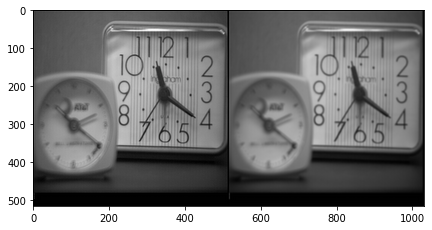

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


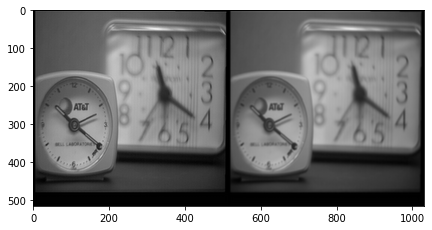

(1, 512, 512)


In [ ]:
#Test simplest deconvolution
import skimage.restoration as rst
us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=1)
us_noisy_np = pil_to_np(us_noisy_pil)

mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=1)
mr_noisy_np = pil_to_np(mr_noisy_pil)

psf = np.ones((5,5))/25

deconvolved_us = rst.richardson_lucy (us_noisy_np[0,:,:], psf, iterations=1)[None,:,:] #deconvolution
deconvolved_mr = rst.richardson_lucy (mr_noisy_np[0,:,:], psf, iterations=1)[None,:,:]

plot_image_grid([us_noisy_np,deconvolved_us], 4, 5)
plot_image_grid([mr_noisy_np,deconvolved_mr], 4, 5)

#original images
o_us_np = us_noisy_np 
o_mr_np = mr_noisy_np

us_noisy_np = deconvolved_us
us_noisy_pil = np_to_pil(deconvolved_us)
mr_noisy_np = deconvolved_mr
mr_noisy_pil = np_to_pil(deconvolved_mr)
print(us_noisy_np.shape)

In [ ]:
#Test
a = torch.randn(1,2,3)
b = torch.randn(1,2,3)
c = a * b #same as np.multiply()
print(a)
print(b)
print(c)
a = np.array([1,2,3,4]).reshape(2,2)
b = np.array([1,2,3,4]).reshape(2,2)
# print(np.dot(a,b))
# print(np.multiply(a,b))

c = np.append(a,b)
c = np.append(c,b)
c = np.array([0.3]*4)

b = np.ones(3)
a = np.random.rand(4,8)
m1 = np.dot(a,a.transpose())
m2 = np.zeros((4,4))

for i in range(a.shape[1]):
    temp_a = a[:,i][:,None]
    m2 += np.dot(temp_a, temp_a.transpose())  

tensor([[[-0.5299,  0.7594,  0.5992],
         [ 1.2207,  0.3775, -1.0931]]])
tensor([[[-1.2411,  1.2493, -0.7270],
         [-0.1303,  0.1323,  0.1134]]])
tensor([[[ 0.6576,  0.9488, -0.4356],
         [-0.1590,  0.0500, -0.1240]]])


In [ ]:
import inspect
# print(inspect.getsource(crop_image))
print(inspect.getsourcefile(crop_image))
print(inspect.getsource(np_to_pil))

/content/utils/common_utils.py
def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
#     ar = img_np.astype(np.uint16)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)



In [ ]:
out_np = torch_to_np(net(net_input))
# q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
#Test
a = abs(np.random.randn(2,2))
print(a)
b = np.square(a)
c = np.sqrt(b)
print(b)
print(c)


[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]
[[4.48903262 1.38034368]
 [0.36701177 0.53842659]]
[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]


In [ ]:
import matlab.engine
import numpy as np
from utils.common_utils import *
size = 6

a = np.ones(size**2).reshape(size,size)
b = np.ones(size**2).reshape(size,size)
[sg1, sg2] = sensor_gain(a,b,2)

mat_a = matlab.double(a.tolist())
mat_b = matlab.double(b.tolist())

eng = matlab.engine.start_matlab()
beta = eng.SensorGain(mat_a,mat_b) #only return the first variable
print(sg1)
print(beta)


[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475]]


(1, 512, 512)
(1, 512, 512)


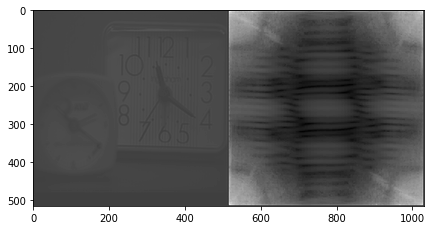

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.05057245e-02, ...,
         1.02547060e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 3.17448162e-04, ...,
         1.04729402e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [ ]:
import numpy as np
from skimage.restoration import (denoise_wavelet, estimate_sigma)
import matplotlib.pyplot as plt

print(us_noisy_np.shape)

# a = np.random.randn(2,3)
a = us_noisy_np
c = np.log(abs(np.fft.fft2(a[0])))
deltaC = c - medfilt2d(c)
lamb = 0.05*abs(deltaC)
r = np.sign(deltaC)*np.maximum(0,abs(deltaC)-lamb)
gr = c - r
# plt.plot(gr)

sigma_est = estimate_sigma(gr) 
im_visushrink = denoise_wavelet(gr, method = 'VisuShrink',mode = 'soft',wavelet_levels = 3,sigma = sigma_est,rescale_sigma=True)[None,:,:]
print(im_visushrink.shape)
plot_image_grid([a,im_visushrink], 4, 5)


In [ ]:

import torch.nn as nn
import torch
 
 
im = torch.randn(1, 1, 5, 5)
print(im.shape)
c = nn.Conv2d(1, 1, kernel_size=2, stride=2, padding=1)
output = c(im)
print(torch.norm(output,p=1))
 


torch.Size([1, 1, 5, 5])
tensor(2.9032, grad_fn=<NormBackward1>)
